# Component 2
## (Vehicle Damage Insurance Claim Verification)

The goal of this exercise is to develop a Convolutional Neural Network (CNN) model capable 
of classifying different types of vehicle damages based on images. The categories of vehicle 
damage include crack, scratch, tire flat, dent, glass shatter and lamp broken. The model should 
be trained to automatically assess the legitimacy of vehicle damage claims, which is essential 
for insurance verification. In this exercise, you will build a CNN to accurately identify the 
damage type from an image, aiding in quick and reliable claim assessment. You will train this 
model using the Vehicle Damage Insurance Verification dataset from Kaggle.

In [19]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



import os     
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.optimizers import SGD

In [3]:
train_df = pd.read_csv("./CNN/train/train.csv")
train_df

image_id  filename  label
0            1     1.jpg      2
1            2     2.jpg      4
2            3     3.jpg      2
3            4     4.jpg      3
4            5     5.jpg      5
...        ...       ...    ...
7195      7196  7196.jpg      4
7196      7197  7197.jpg      4
7197      7198  7198.jpg      4
7198      7199  7199.jpg      2
7199      7200  7200.jpg      2

[7200 rows x 3 columns]

In [5]:
train_df['label'].unique()

array([2, 4, 3, 5, 6, 1], dtype=int64)

In [7]:
def create_dataset(df, label_map, image_dir, new_filename):
    for index, row in df.iterrows():                           #Iterate through each row in the dataframe
        try:
            filename = row["filename"]                         #Get the filename from the current row
            label = row["label"]                               #Get the label from the current row
            
            if label not in label_map:                         #Skip if the label is not in the label map
                print(f"Skipping row {index}: Ivalid label '{label}' for file {filename}")
                continue
            label_class = label_map[label]                     #Map the label to its class name
            image_path = os.path.join(image_dir, filename)     #Full path to the source image
            join_dir = os.path.join(new_filename, label_class) #Target directory based on label class
            if not os.path.exists(image_path):                 #Check if source image exists
                print(f"Skipping {filename}: Source file not found at {image_path}")
                continue
            try:
                os.makedirs(join_dir, exist_ok=True)            #Create target directory if it doesn't exist
            except OSError as e:                                #Handle errors during directory creation
                print(f"Error creating directory {join.dir}: {e}")
                continue
            join_path = os.path.join(join_dir, filename)        #Define full target path for the image
            try:
                shutil.copy2(image_path, join_path)             #Copy the image to the target location
            except IOError as e:                                #Handle errors during file copy
                print(f"Error creating directory {join.dir}: {e}")
                continue
        except Exception as e:                                  #Catch any unexpected errors during row processing
            print(f"Unexpected error processing row {index}: {e}")
            continue

In [9]:
class_label_mapping = {
    1: "crack",            #1 corresponds to a crack damage
    2: "scratch",          #2 corresponds to a scratch damage
    3: "flat tire",        #3 corresponds to a flat tire
    4: "dent",             #4 corresponds to a dent on the vehicle body
    5: "shattered glass",  #5 corresponds to broken/shattered glass
    6: "broken lamp"       #6 corresponds to a broken vehicle lamp
}

In [11]:
create_dataset(df=train_df, label_map=class_label_mapping, image_dir="./CNN/train/images", new_filename="./CNN/new_train")

In [13]:
image_dataset = image_dataset_from_directory(
    directory="./CNN/new_train",    #Path to the directory containing the sorted images
    labels="inferred",              #Infer labels from the subdirectory names
    label_mode="int",               #Labels will be encoded as integers
    batch_size=32,                  # Number of images to load per batch
    image_size=(255, 255)           #Resize all images to 255x255 pixels
)

Found 7200 files belonging to 6 classes.


Image batch shape: (32, 255, 255, 3)
Label batch shape: (32,)


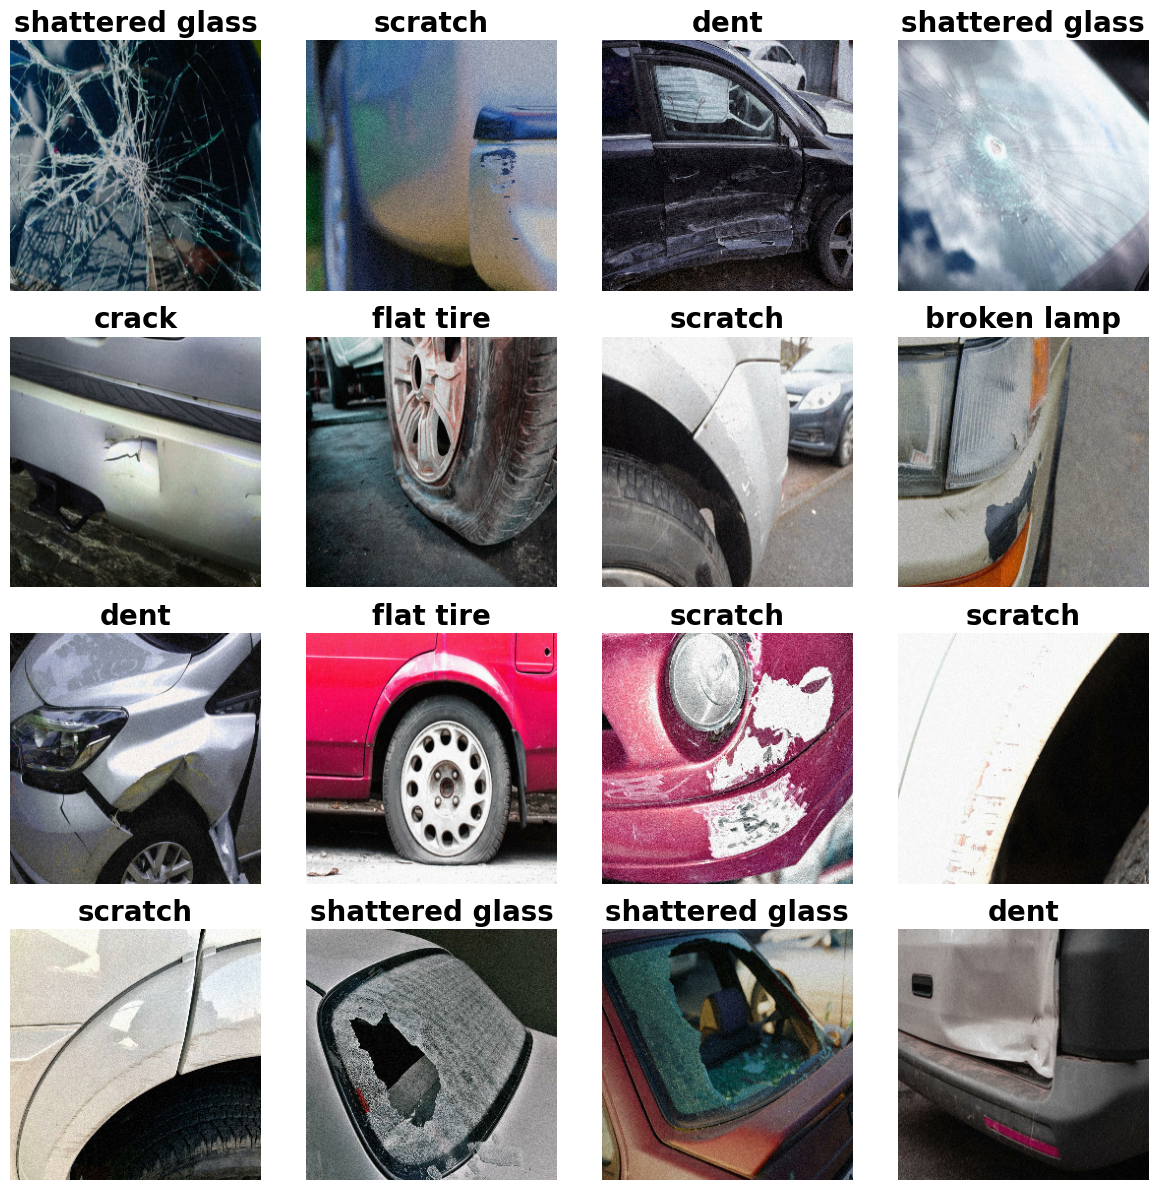

In [15]:
class_names = image_dataset.class_names                #Get the list of class names from the dataset
class_names                                            #Display the class names

for images, labels in image_dataset.take(1):           #Take one batch of images and labels from the dataset
    print(f"Image batch shape: {images.shape}")        #Print the shape of the image batch
    print(f"Label batch shape: {labels.shape}")        #Print the shape of the label batch
    figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))   #Create a 4x4 grid of subplots (16 images)
    
    for index, image in enumerate(images[:16]):        #Loop over the first 16 images in the batch
        row = index // 4                               #Determine the row position
        col = index % 4                                #Determine the column position
        
        ax = axes[row, col]                            #Get the correct subplot
        
        ax.imshow(image.numpy().astype(int))           #Convert the image tensor to an integer numpy array and display it
        ax.axis("off")                                 #Turn off axis
        
        ax.set_title(class_names[labels[index].numpy()], fontweight="bold", fontsize=20) #Set the title to the class name

plt.tight_layout()                                      #Adjust subplot layout to prevent overlap

plt.show()                                              #Display the full figure

In [21]:
#Function convert tensorflow dataset into numpy arrays
def conv_to_numpy(dataset):
    images = []                                 #Initialize empty list to store images
    labels = []                                 #Initialize empty list to store labels
    for image, label in dataset:                #Iterate through each batch in the dataset
        images.extend(image.numpy())            #Convert images to NumPy and add to list
        labels.extend(label.numpy())            #Convert labels to NumPy and add to list
        
    return np.array(images), np.array(labels)   #Return as NumPy arrays

images, labels = conv_to_numpy(image_dataset)   #Convert the entire TensorFlow dataset into NumPy arrays

#Split the dataset into training and testing sets (80% train, 20% test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, random_state=42, test_size=0.2)

#Print the size of the training and testing datasets
print(f"The training test size is: {len(train_images)}")
print(f"The testing test size is: {len(test_images)}")

The training test size is: 5760
The testing test size is: 1440


Normalize the train images and convert the labels using one hot encoder

In [24]:
#Display the array of labels corresponding to the training images
train_labels

array([4, 5, 4, ..., 4, 2, 4])

In [26]:
#One-hot encode the training labels into categorical format
train_label_cat = to_categorical(train_labels, num_classes=6)
#Display the one-hot encoded training labels
train_label_cat

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [28]:
#Display the array of images
train_images

array([[[[ 46.22413 ,  47.22413 ,  52.22413 ],
         [ 63.186295,  66.32747 ,  71.04512 ],
         [ 48.603462,  56.603462,  59.462288],
         ...,
         [ 59.688435,  65.61094 ,  87.61094 ],
         [ 73.45528 ,  75.66695 ,  98.59639 ],
         [ 76.42417 ,  76.42417 , 100.42417 ]],

        [[ 42.01292 ,  42.01292 ,  50.01292 ],
         [ 45.551422,  49.551422,  52.551422],
         [ 45.52895 ,  54.52895 ,  52.161938],
         ...,
         [ 62.13356 ,  67.13356 ,  89.13356 ],
         [ 57.6072  ,  59.6072  ,  82.6072  ],
         [ 66.37863 ,  66.37863 ,  90.37863 ]],

        [[ 82.600685,  82.600685,  92.19469 ],
         [ 83.1481  ,  86.21869 ,  91.07751 ],
         [ 42.18224 ,  51.18224 ,  48.69204 ],
         ...,
         [ 65.2176  ,  67.923485,  87.51172 ],
         [ 67.013885,  68.03464 ,  88.32875 ],
         [ 62.084816,  59.378933,  80.67305 ]],

        ...,

        [[211.90411 , 206.90411 , 184.90411 ],
         [189.67825 , 184.67825 , 162.67825 ]

In [30]:
#Normalize the images by dividing pixel values by 255 to scale them to [0, 1]
train_images_norm = train_images / 255
#Check the maximum pixel value in the normalized images (should be 1.0)
train_images_norm.max()

1.0

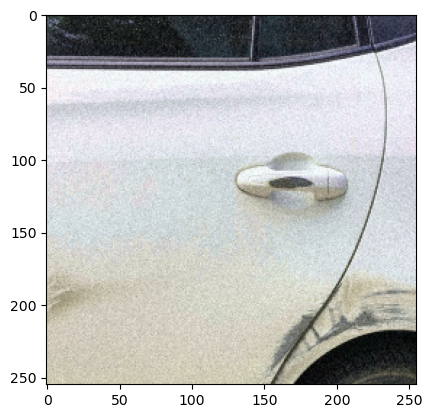

In [32]:
#Display the first normalized image
plt.imshow(train_images_norm[0])
plt.show()

Image Transformation for Augumentation

In [35]:
train_datagen = ImageDataGenerator(rotation_range=20,         #Randomly rotate images within a 20-degree range
                                   width_shift_range=0.1,     #Randomly shift images horizontally by up to 10% of the width
                                   height_shift_range=0.1,    #Randomly shift images vertically by up to 10% of the height
                                   horizontal_flip=True,      #Randomly flip images horizontally (left to right)
                                   vertical_flip=False,       #Do not flip images vertically (top to bottom)
                                   shear_range=0.10,          #Apply random shear transformations (distort the image) with a range of 10%
                                   zoom_range=0.10,           #Randomly zoom in or out by up to 10%
                                   validation_split=0.2)      #Reserve 20% of data for validation (for split during training)

In [37]:
train_datagen.fit(train_images_norm)

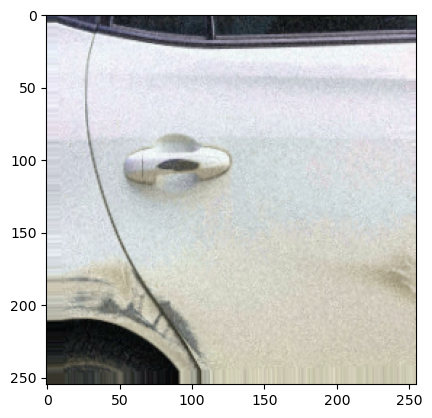

In [39]:
#Applying a random augmentation to the first image in the normalized dataset
new_image = train_datagen.random_transform(train_images_norm[0])
plt.imshow(new_image)
plt.show()

# Building a CNN Model

# Model 1

## Adam, 32 batch size, 50% dropout

In [41]:
#Print the shape of the normalized training images
print("Train images shape:", train_images_norm.shape)
#Print the shape of the one-hot encoded training labels
print("Train labels shape:", train_label_cat.shape)

Train images shape: (5760, 255, 255, 3)
Train labels shape: (5760, 6)


In [43]:
#Create an instance of the Sequential class.
model = Sequential()

#Add first convolutional layer
model.add(Input(shape=(255,255,3)))         
model.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu',padding = 'same'))

# Add a pooling layer that uses max pooling with a pool size of 2x2.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a second convolutional layer, 64 filters
model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2))) 

# Add a third convolutional layer, now with 128 filters.
model.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

#Add a flatten layer
model.add(Flatten())

# Add a Dense (i.e. fully connected) layer with 64 neurons and the relu activation function.
model.add(Dense(64,activation = 'relu'))

# Apply a dropout rate of 50% to the dense layer.
model.add(Dropout(0.5))

# The output layer needs 6 units, corresponding to the 6 output classes. We use the softmax
# activation function, which means the resulting output values will represent the probabilities
# for each of the 6 class labels.
model.add(Dense(6,activation = 'softmax'))

# Print a summary of the model.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
batch_size = 32
history = model.fit(
    train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "training"
    ),
    epochs = 100,
    validation_data = train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "validation"))

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.2895 - loss: 1.6871 - val_accuracy: 0.3872 - val_loss: 1.4143
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.3715 - loss: 1.4456 - val_accuracy: 0.4601 - val_loss: 1.3415
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.4152 - loss: 1.3623 - val_accuracy: 0.4826 - val_loss: 1.2557
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4334 - loss: 1.3028 - val_accuracy: 0.5043 - val_loss: 1.2037
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.4537 - loss: 1.2605 - val_accuracy: 0.4714 - val_loss: 1.2133
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.4670 - loss: 1.2509 - val_accuracy: 0.5122 - val_loss: 1.1693
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.4737 - loss: 1.2165 - val_accuracy: 0.4809 - val_loss: 1.1780
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.4767 - loss: 1.2184 - 

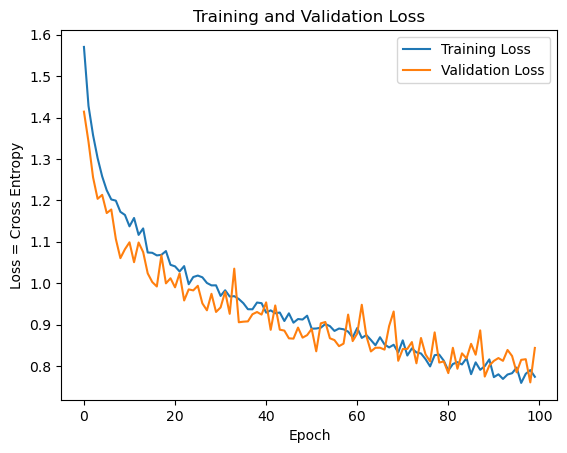

In [53]:
#Checking for overfitting
#Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')

#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

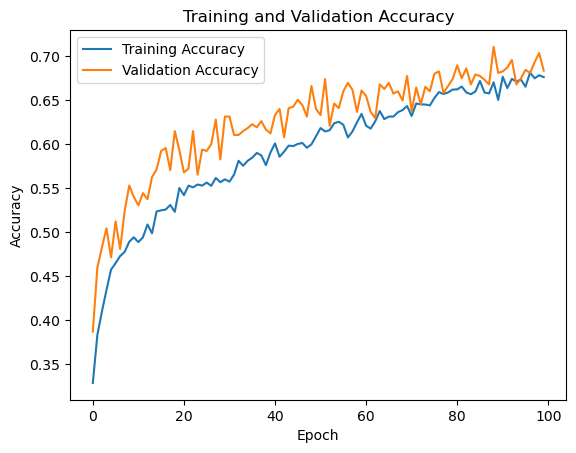

In [54]:
#Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

In [55]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 314ms/step


In [56]:
#Print the classification report 
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.85      0.75       706
           1       1.00      0.01      0.03       143
           2       0.64      0.76      0.70      1632
           3       0.87      0.97      0.92       421
           4       0.82      0.66      0.73      1905
           5       0.95      0.96      0.95       953

    accuracy                           0.76      5760
   macro avg       0.83      0.70      0.68      5760
weighted avg       0.78      0.76      0.76      5760



<Figure size 2000x3000 with 0 Axes>

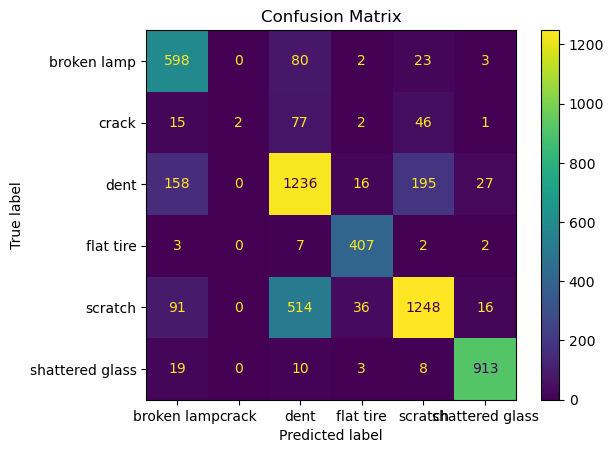

In [57]:
#Print the confusion matrix
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

# Model 2

## SGD, learn rate = 0.01, 32 batch size, 50% dropout

In [59]:
#Create an instance of the Sequential class.
model = Sequential()

#Add first convolutional layer
model.add(Input(shape=(255,255,3)))         
model.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu',padding = 'same'))

# Add a pooling layer that uses max pooling with a pool size of 2x2.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a second convolutional layer, 64 filters
model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2))) 

# Add a third convolutional layer, now with 128 filters.
model.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

#Add a flatten layer
model.add(Flatten())

# Add a Dense (i.e. fully connected) layer with 64 neurons and the relu activation function.
model.add(Dense(64,activation = 'relu'))

# Apply a dropout rate of 50% to the dense layer.
model.add(Dropout(0.5))

# The output layer needs 6 units, corresponding to the 6 output classes. We use the softmax
# activation function, which means the resulting output values will represent the probabilities
# for each of the 6 class labels.
model.add(Dense(6,activation = 'softmax'))

# Print a summary of the model.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Compile the model with categorical cross-entropy loss and SGD optimizer
#categorical_crossentropy - loss function during model training
#accuracy - Evaluation measure
#SGD - Stochastic Gradient Descent
#import SGD
from tensorflow.keras.optimizers import SGD
# learning_rate=0.01 specifies the step size of the updates to the weights during training. 
# momentum=0.9 is a parameter that helps the optimizer to accelerate in the direction of the gradient and dampen oscillations.
# Higher values of momentum allow the optimizer to move more smoothly towards the global minimum 
# and reduce the chance of getting stuck in local minima.
# Create an instance of the SGD class,
# and set the learning rate.
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
batch_size = 32
history = model.fit(
    train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "training"
    ),
    epochs = 100,
    validation_data = train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "validation"))

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.3036 - loss: 1.6366 - val_accuracy: 0.3264 - val_loss: 1.5347
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.3405 - loss: 1.5210 - val_accuracy: 0.3837 - val_loss: 1.4319
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.3705 - loss: 1.4728 - val_accuracy: 0.3333 - val_loss: 1.4809
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.3698 - loss: 1.4647 - val_accuracy: 0.4158 - val_loss: 1.3925
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.3930 - loss: 1.4315 - val_accuracy: 0.4141 - val_loss: 1.3922
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.3975 - loss: 1.4239 - val_accuracy: 0.4375 - val_loss: 1.3316
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.3788 - loss: 1.4372 - val_accuracy: 0.4323 - val_loss: 1.3322
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.4061 - loss: 1.3547 - 

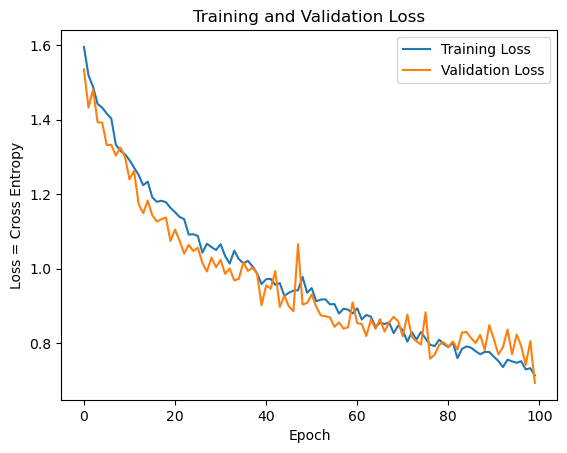

In [62]:
#checking for overfitting
#Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

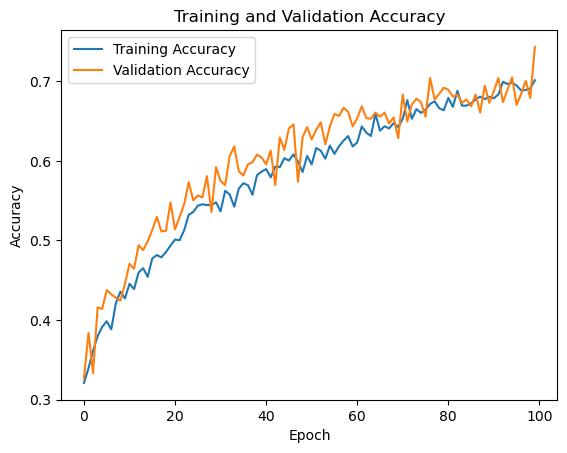

In [63]:
#Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

In [64]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 58s 319ms/step


In [65]:
from sklearn.metrics import classification_report
#Print the classification report 
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       706
           1       0.82      0.44      0.57       143
           2       0.78      0.71      0.74      1632
           3       0.83      0.97      0.89       421
           4       0.78      0.78      0.78      1905
           5       0.91      0.98      0.94       953

    accuracy                           0.81      5760
   macro avg       0.81      0.78      0.79      5760
weighted avg       0.80      0.81      0.80      5760



<Figure size 2000x3000 with 0 Axes>

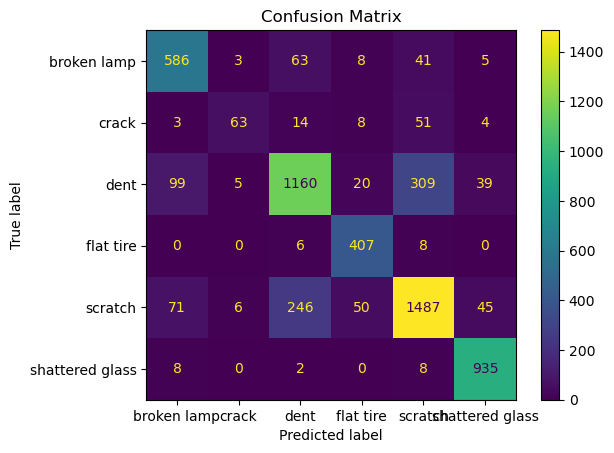

In [66]:
#Print the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

# Model 3

## SGD, learn rate = 0.01, 128 batch size, 50% dropout

In [71]:
#Create an instance of the Sequential class.
model = Sequential()

#Add first convolutional layer
model.add(Input(shape=(255,255,3)))         
model.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu',padding = 'same'))

# Add a pooling layer that uses max pooling with a pool size of 2x2.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a second convolutional layer, 64 filters
model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2))) 

# Add a third convolutional layer, now with 128 filters.
model.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

#Add a flatten layer
model.add(Flatten())

# Add a Dense (i.e. fully connected) layer with 64 neurons and the relu activation function.
model.add(Dense(64,activation = 'relu'))

# Apply a dropout rate of 50% to the dense layer.
model.add(Dropout(0.5))

# The output layer needs 6 units, corresponding to the 6 output classes. We use the softmax
# activation function, which means the resulting output values will represent the probabilities
# for each of the 6 class labels.
model.add(Dense(6,activation = 'softmax'))

# Print a summary of the model.
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
#Compile the model with categorical cross-entropy loss and SGD optimizer
#categorical_crossentropy - loss function during model training
#accuracy - Evaluation measure
#SGD - Stochastic Gradient Descent
from tensorflow.keras.optimizers import SGD
#learning_rate=0.01 specifies the step size of the updates to the weights during training. 
#momentum=0.9 is a parameter that helps the optimizer to accelerate in the direction of the gradient and dampen oscillations.
#Higher values of momentum allow the optimizer to move more smoothly towards the global minimum 
#and reduce the chance of getting stuck in local minima.
#Create an instance of the SGD class,
#and set the learning rate.
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
batch_size = 128
history = model.fit(
    train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "training"
    ),
    epochs = 100,
    validation_data = train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "validation"))

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - accuracy: 0.3139 - loss: 1.6442 - val_accuracy: 0.3238 - val_loss: 1.5291
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - accuracy: 0.3361 - loss: 1.5290 - val_accuracy: 0.3898 - val_loss: 1.4461
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 237s 7s/step - accuracy: 0.3654 - loss: 1.4640 - val_accuracy: 0.4036 - val_loss: 1.3778
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 217s 6s/step - accuracy: 0.3814 - loss: 1.4112 - val_accuracy: 0.4280 - val_loss: 1.3314
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.4053 - loss: 1.3586 - val_accuracy: 0.4592 - val_loss: 1.3119
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.4159 - loss: 1.3706 - val_accuracy: 0.4193 - val_loss: 1.3073
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - accuracy: 0.4266 - loss: 1.3081 - val_accuracy: 0.4453 - val_loss: 1.3033
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.4244 - loss: 1.3095 - val_accuracy: 0.

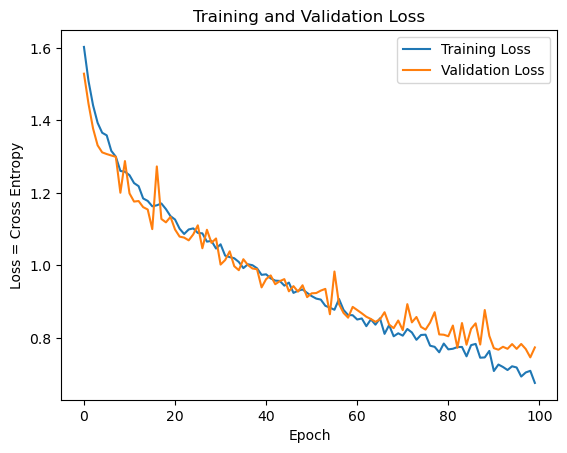

In [79]:
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

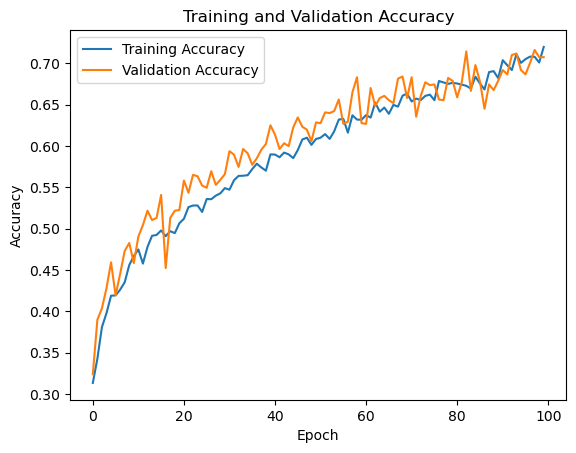

In [81]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

In [83]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 304ms/step


In [85]:
from sklearn.metrics import classification_report
#Print the classification report 
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       706
           1       1.00      0.21      0.35       143
           2       0.79      0.72      0.76      1632
           3       0.95      0.95      0.95       421
           4       0.75      0.84      0.79      1905
           5       0.89      0.97      0.93       953

    accuracy                           0.82      5760
   macro avg       0.87      0.75      0.77      5760
weighted avg       0.82      0.82      0.81      5760



<Figure size 2000x3000 with 0 Axes>

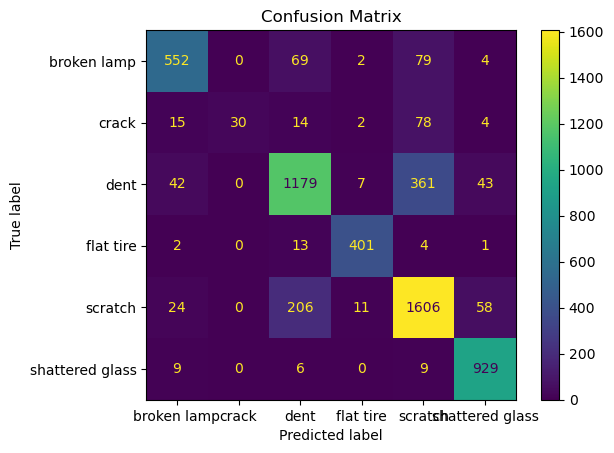

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

# Model 4

## SGD, learn rate = 0.001, 32 batch size, 50% dropout

In [137]:
#Create an instance of the Sequential class.
model = Sequential()

#Add first convolutional layer
model.add(Input(shape=(255,255,3)))         
model.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu',padding = 'same'))

# Add a pooling layer that uses max pooling with a pool size of 2x2.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a second convolutional layer, 64 filters
model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2))) 

# Add a third convolutional layer, now with 128 filters.
model.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

#Add a flatten layer
model.add(Flatten())

# Add a Dense (i.e. fully connected) layer with 64 neurons and the relu activation function.
model.add(Dense(64,activation = 'relu'))

# Apply a dropout rate of 50% to the dense layer.
model.add(Dropout(0.5))

# The output layer needs 6 units, corresponding to the 6 output classes. We use the softmax
# activation function, which means the resulting output values will represent the probabilities
# for each of the 6 class labels.
model.add(Dense(6,activation = 'softmax'))

# Print a summary of the model.
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [141]:
batch_size = 32
history = model.fit(
    train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "training"
    ),
    epochs = 100,
    validation_data = train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "validation"))

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.2792 - loss: 1.6730 - val_accuracy: 0.3168 - val_loss: 1.5632
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.3318 - loss: 1.5493 - val_accuracy: 0.3290 - val_loss: 1.5437
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.3351 - loss: 1.5382 - val_accuracy: 0.3733 - val_loss: 1.4893
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3361 - loss: 1.5110 - val_accuracy: 0.3837 - val_loss: 1.4305
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.3840 - loss: 1.4428 - val_accuracy: 0.3733 - val_loss: 1.4367
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.3720 - loss: 1.4517 - val_accuracy: 0.4123 - val_loss: 1.3809
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.3887 - loss: 1.4189 - val_accuracy: 0.3872 - val_loss: 1.4174
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.3928 - loss: 1.4122 - 

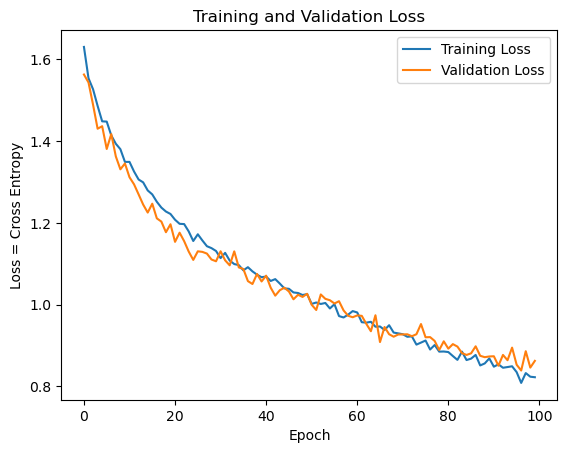

In [151]:
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

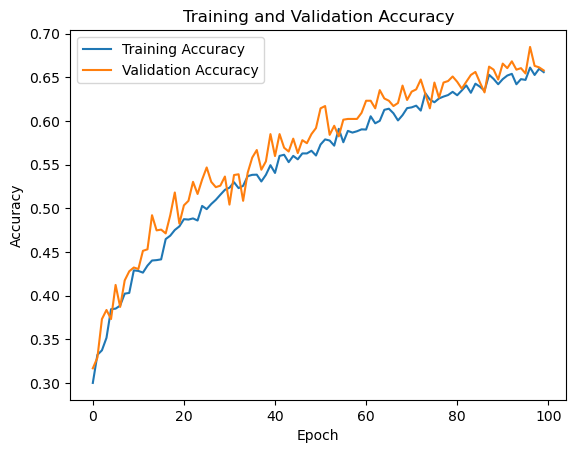

In [153]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

In [155]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 276ms/step


In [157]:
#Print the classification report 
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75       706
           1       1.00      0.03      0.07       143
           2       0.72      0.73      0.72      1632
           3       0.90      0.92      0.91       421
           4       0.79      0.71      0.75      1905
           5       0.85      0.97      0.90       953

    accuracy                           0.77      5760
   macro avg       0.82      0.70      0.68      5760
weighted avg       0.78      0.77      0.76      5760



<Figure size 2000x3000 with 0 Axes>

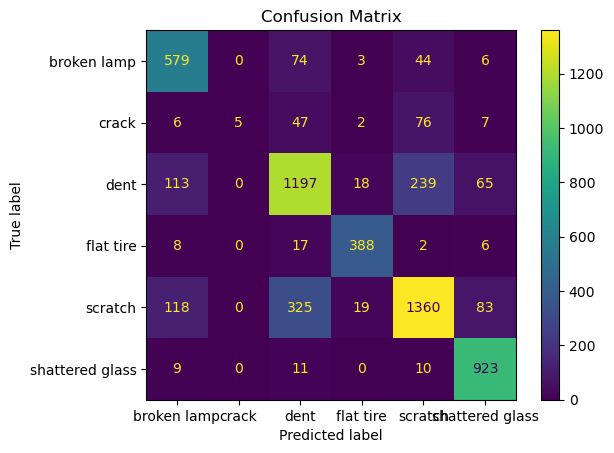

In [159]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()

# Model 5

## SGD, learn rate = 0.01, 32 batch size, 20% dropout

In [10]:
#Create an instance of the Sequential class.
model = Sequential()

#Add first convolutional layer
model.add(Input(shape=(255,255,3)))         
model.add(Conv2D(filters=32,kernel_size=(3,3), activation = 'relu',padding = 'same'))

# Add a pooling layer that uses max pooling with a pool size of 2x2.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a second convolutional layer, 64 filters
model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2))) 

# Add a third convolutional layer, now with 128 filters.
model.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

#Add a flatten layer
model.add(Flatten())

# Add a Dense (i.e. fully connected) layer with 64 neurons and the relu activation function.
model.add(Dense(64,activation = 'relu'))

# Apply a dropout rate of 20% to the dense layer.
model.add(Dropout(0.2))

# The output layer needs 6 units, corresponding to the 6 output classes. We use the softmax
# activation function, which means the resulting output values will represent the probabilities
# for each of the 6 class labels.
model.add(Dense(6,activation = 'softmax'))

# Print a summary of the model.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,502 (28.48 MB)

 Trainable params: 7,466,502 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
batch_size = 32
history = model.fit(
    train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "training"
    ),
    epochs = 100,
    validation_data = train_datagen.flow(
        train_images_norm,
        train_label_cat,
        batch_size = batch_size,
        subset = "validation"))

Epoch 1/100


C:\Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 375ms/step - accuracy: 0.3102 - loss: 1.5859 - val_accuracy: 0.3602 - val_loss: 1.4766
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - accuracy: 0.3636 - loss: 1.4728 - val_accuracy: 0.3750 - val_loss: 1.4100
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 379ms/step - accuracy: 0.3914 - loss: 1.4207 - val_accuracy: 0.3837 - val_loss: 1.4110
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 401ms/step - accuracy: 0.3789 - loss: 1.4254 - val_accuracy: 0.4271 - val_loss: 1.3543
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 381ms/step - accuracy: 0.4268 - loss: 1.3531 - val_accuracy: 0.4653 - val_loss: 1.3086
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 55s 377ms/step - accuracy: 0.4294 - loss: 1.3252 - val_accuracy: 0.4592 - val_loss: 1.2114
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 379ms/step - accuracy: 0.4566 - loss: 1.2520 - val_accuracy: 0.4957 - val_loss: 1.1919
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 57s 386ms/step - accuracy: 0.4822 - loss: 1.199

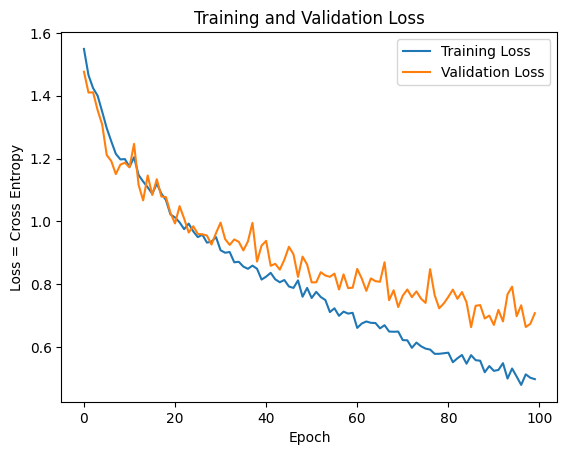

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

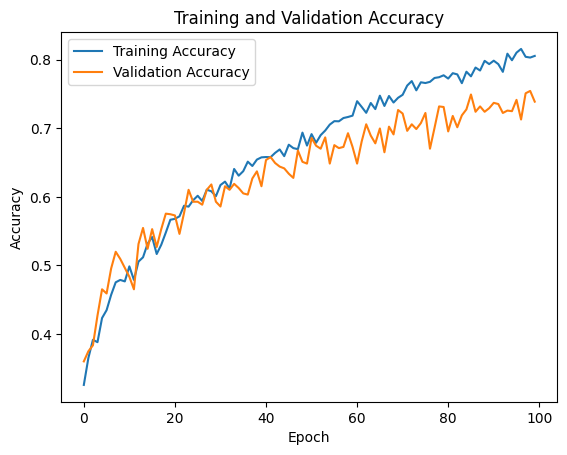

In [19]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

In [20]:
y_pred = np.argmax(model.predict(train_images_norm), axis=-1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step


In [23]:
#Print the classification report 
print(classification_report(train_labels, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       696
           1       0.95      0.75      0.84       139
           2       0.87      0.83      0.85      1648
           3       0.96      0.95      0.95       445
           4       0.85      0.89      0.87      1887
           5       0.96      0.99      0.97       945

    accuracy                           0.89      5760
   macro avg       0.91      0.88      0.90      5760
weighted avg       0.89      0.89      0.89      5760



<Figure size 2000x3000 with 0 Axes>

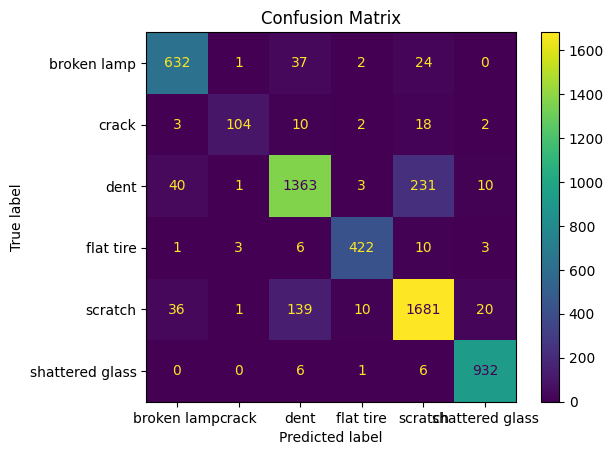

In [26]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(train_labels,y_pred, display_labels=class_names)
plt.title('Confusion Matrix')
plt.show()